# Binary image classification

Here we'll take a problem of binary image classifing.

In [ ]:
#|code-fold: true
#|output: false
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from pytorched.step_by_step import StepByStep
import platform
from PIL import Image
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

In [ ]:
#|code-fold: true 
def show_image(im, cmap=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(im, cmap=cmap)
    plt.grid(False)
    plt.show()

# Data

We'll use generated data, where images with horizontal and vertical lines are considered label `0`, while diagonal have label `1`.

In [ ]:
#|code-fold: true
def gen_img(start, target, fill=1, img_size=10):
    # Generates empty image
    img = np.zeros((img_size, img_size), dtype=float)

    start_row, start_col = None, None

    if start > 0:
        start_row = start
    else:
        start_col = np.abs(start)

    if target == 0:
        if start_row is None:
            img[:, start_col] = fill
        else:
            img[start_row, :] = fill
    else:
        if start_col == 0:
            start_col = 1
        
        if target == 1:
            if start_row is not None:
                up = (range(start_row, -1, -1), 
                      range(0, start_row + 1))
            else:
                up = (range(img_size - 1, start_col - 1, -1), 
                      range(start_col, img_size))
            img[up] = fill
        else:
            if start_row is not None:
                down = (range(start_row, img_size, 1), 
                        range(0, img_size - start_row))
            else:
                down = (range(0, img_size - 1 - start_col + 1), 
                        range(start_col, img_size))
            img[down] = fill
    
    return 255 * img.reshape(1, img_size, img_size)


def generate_dataset(img_size=10, n_images=100, binary=True, seed=17):
    np.random.seed(seed)

    starts = np.random.randint(-(img_size - 1), img_size, size=(n_images,))
    targets = np.random.randint(0, 3, size=(n_images,))
    
    images = np.array([gen_img(s, t, img_size=img_size) 
                       for s, t in zip(starts, targets)], dtype=np.uint8)
    
    if binary:
        targets = (targets > 0).astype(int)
    
    return images, targets

def plot_images(images, targets, n_plot=30):
    n_rows = n_plot // 6 + ((n_plot % 6) > 0)
    fig, axes = plt.subplots(n_rows, 6, figsize=(9, 1.5 * n_rows))
    axes = np.atleast_2d(axes)
    
    for i, (image, target) in enumerate(zip(images[:n_plot], targets[:n_plot])):
        row, col = i // 6, i % 6    
        ax = axes[row, col]
        ax.set_title('#{} - Label:{}'.format(i, target), {'size': 12})
        # plot filter channel in grayscale
        ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.label_outer()

    plt.tight_layout()
    return fig

In [ ]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

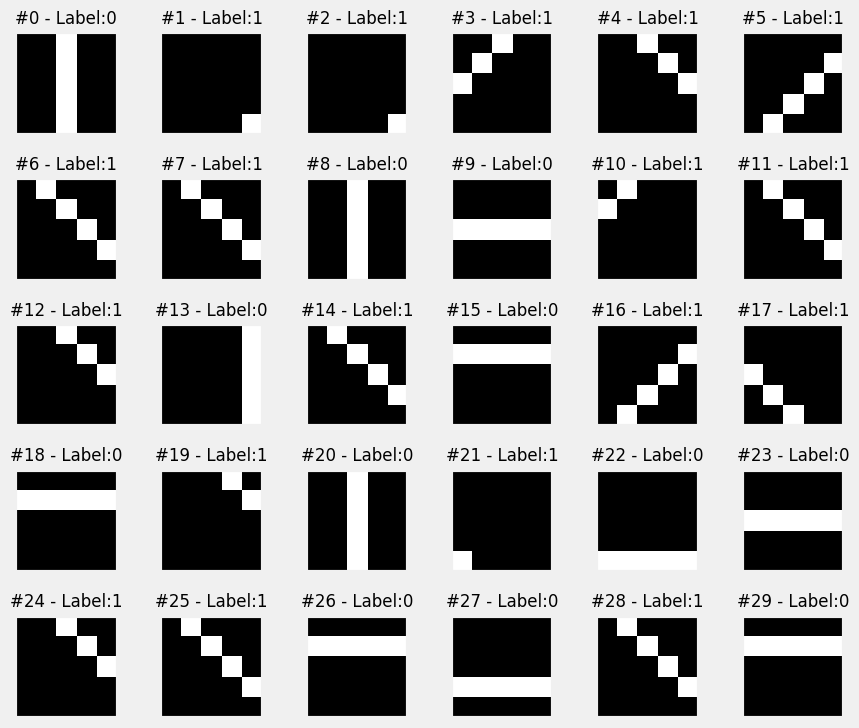

In [ ]:
fig = plot_images(images, labels, n_plot=30)

# Data preparation

In [ ]:
x_tensor = torch.as_tensor(images / 255.).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()  # reshaped this to (N,1) tensor

PyTorch has `Dataset` class, `TensorDataset` as a subclass, and we can create custom subclasses too that can handle **data augmentation**:

In [ ]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

A `torch.utils.data.random_split` method can split indices into train and valid (it requires exact number of images to split):

In [ ]:
torch.manual_seed(13)
N = len(x_tensor)
n_train = int(.8*N)
n_val = N - n_train
train_subset, val_subset = random_split(x_tensor, [n_train, n_val])
train_subset

<torch.utils.data.dataset.Subset>

we just need indices:

In [ ]:
train_idx = train_subset.indices
val_idx = val_subset.indices

In [ ]:
train_idx[:10]

[118, 170, 148, 239, 226, 146, 168, 195, 6, 180]

# Data augmentation

For data augmentation we only augment training data, so we create training and validation **Composer**:

In [ ]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])

val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

Now we can build train/val `tensors`, `Dataset`s and `DataLoader`s:

In [ ]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

We could stop here and just make loaders:

In [ ]:
# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

or we can even used `WeightedRandomSampler` if we want to balance datasets:

In [ ]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

Note that we don't need a `val_sampler` anymore since we already split datasets:

In [ ]:
train_sampler = make_balanced_sampler(y_train_tensor)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)  

In [ ]:
#| hide
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

# Logistic Regression Model

In [ ]:
lr = 0.1

# Now we can create a model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=True))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [ ]:
sbs_logistic = StepByStep(model_logistic, optimizer_logistic, binary_loss_fn)
sbs_logistic.set_seed()
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(200)

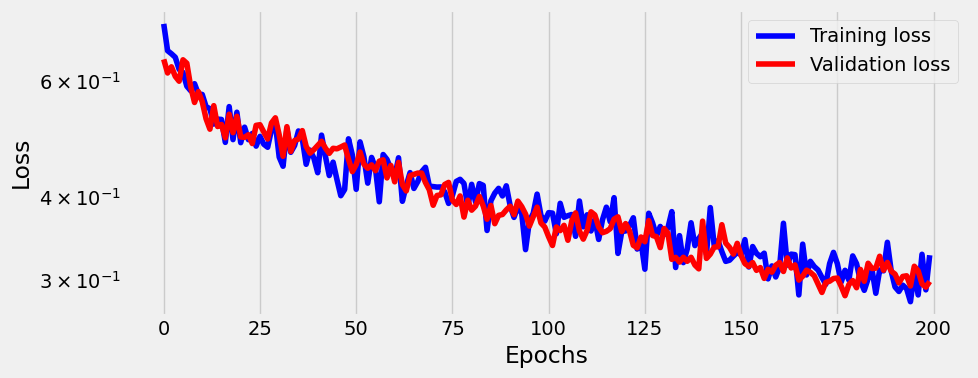

In [ ]:
fig = sbs_logistic.plot_losses()

In [ ]:
#|code-fold: true
print('Correct categories:')
print(sbs_logistic.loader_apply(sbs_logistic.val_loader, sbs_logistic.correct))

Correct categories:
tensor([[24, 24],
        [34, 36]])


After 200 epoch it's almost 100%. Let's add 400 more:

In [ ]:
sbs_logistic.train(400)

In [ ]:
#|code-fold: true
print('Correct categories:')
print(sbs_logistic.loader_apply(sbs_logistic.val_loader, sbs_logistic.correct))

Correct categories:
tensor([[24, 24],
        [36, 36]])


so after 600 epoch model is 100% accurate (at least on 60 samples).

# Deeper Model

In [ ]:
lr = 0.1

# Now we can create a model
model_deeper = nn.Sequential()
model_deeper.add_module('flatten', nn.Flatten())
model_deeper.add_module('linear1', nn.Linear(25, 10, bias=True))
model_deeper.add_module('relu', nn.ReLU())
model_deeper.add_module('linear2', nn.Linear(10, 1, bias=True))
model_deeper.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_deeper = optim.SGD(model_deeper.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [ ]:
sbs_deeper = StepByStep(model_deeper, optimizer_deeper, binary_loss_fn)
sbs_deeper.set_seed()
sbs_deeper.set_loaders(train_loader, val_loader)
sbs_deeper.train(20)

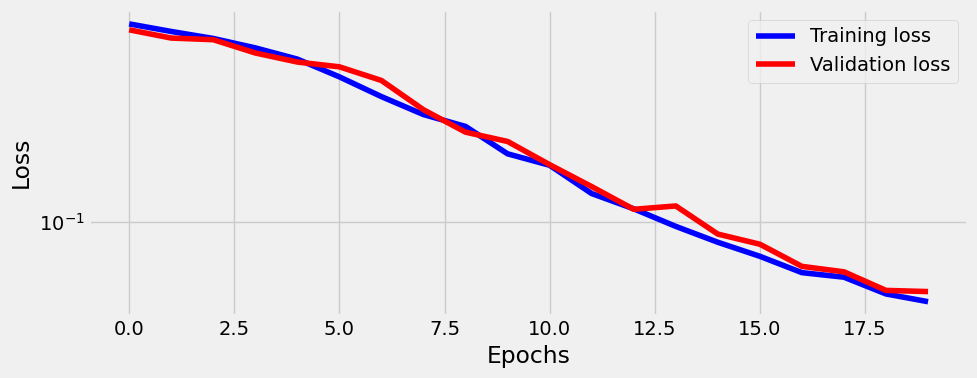

In [ ]:
fig = sbs_deeper.plot_losses()

In [ ]:
#|code-fold: true
print('Correct categories:')
print(sbs_deeper.loader_apply(sbs_deeper.val_loader, sbs_deeper.correct))    

Correct categories:
tensor([[24, 24],
        [36, 36]])


and even after 20 epoch it's 100% accurate. We can train more to flatten the loss though which will surely generalize model:

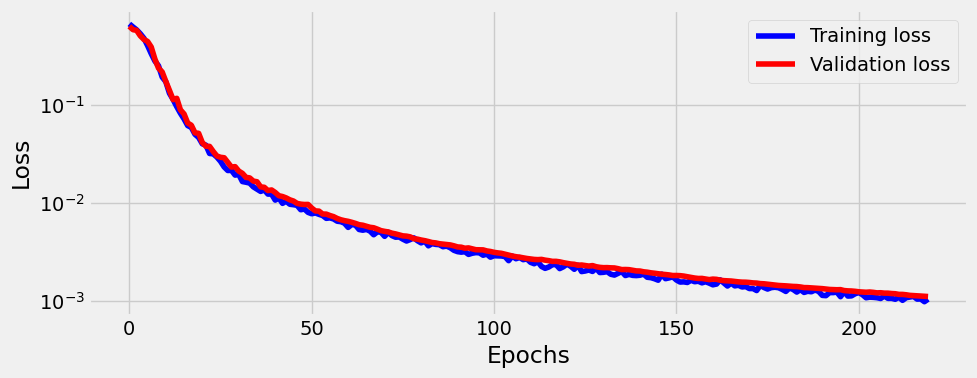

In [ ]:
sbs_deeper.train(200)
fig = sbs_deeper.plot_losses()

And that's it.

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# Appendix

## Some neat model insights

To see the layers:

In [ ]:
sbs_deeper.model

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=25, out_features=10, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

To see particular weights in a layer:

In [ ]:
sbs_deeper.model.linear2.weight.detach()

tensor([[ 0.9241,  0.2535, -1.0762,  0.8478,  0.8018, -1.2926, -2.0408,  1.8996,
         -2.7562,  1.7060]])

In [ ]:
sbs_deeper.count_parameters()

271

The 271 comes from: (25 * 10 + 10 biases) + (10 * 1 + 1 bias) = 260 + 11 = 271

to reset parameters I implemented [this](https://stackoverflow.com/questions/63627997/reset-parameters-of-a-neural-network-in-pytorch) way but this doesn't reset all parameters (for example in `nn.PReLU`) so use caution! 

In [ ]:
sbs_deeper.reset_parameters()

## Note on NCHW vs NHWC formats

The format for images is different between libraries:
- PyTorch uses NCHW
- TensorFlow uses NHWC
- PIL/Matplotlib images are HWC.

In [ ]:
image_r  = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

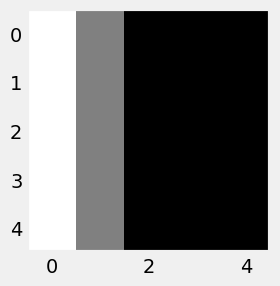

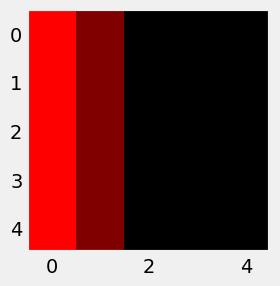

In [ ]:
#|code-fold: true
#|output: false
show_image(image_r, 'gray')
zeros = np.zeros((5,5), dtype=np.uint8)
stacked_red = np.zeros((5,5,3), dtype=np.uint8)  # the format is HxWxX (height X width X channel)
stacked_red[:,:,0] = image_r  
# also same thing can be achieved stacked_red = np.stack([image_r, zeros, zeros], axis=2)
show_image(stacked_red)

In [ ]:
#|code-fold: true
def image_channels(red, green, blue, rgb, gray, rows=(0, 1, 2)):
    fig, axs = plt.subplots(len(rows), 4, figsize=(15, 5.5))

    zeros = np.zeros((5, 5), dtype=np.uint8)

    titles1 = ['Red', 'Green', 'Blue', 'Grayscale Image']
    titles0 = ['image_r', 'image_g', 'image_b', 'image_gray']
    titles2 = ['as first channel', 'as second channel', 'as third channel', 'RGB Image']

    idx0 = np.argmax(np.array(rows) == 0)
    idx1 = np.argmax(np.array(rows) == 1)
    idx2 = np.argmax(np.array(rows) == 2)
    
    for i, m in enumerate([red, green, blue, gray]):
        if 0 in rows:
            axs[idx0, i].axis('off')
            axs[idx0, i].invert_yaxis()
            if (1 in rows) or (i < 3):
                axs[idx0, i].text(0.15, 0.25, str(m.astype(np.uint8)), verticalalignment='top')    
                axs[idx0, i].set_title(titles0[i], fontsize=16)

        if 1 in rows:
            axs[idx1, i].set_title(titles1[i], fontsize=16)
            axs[idx1, i].set_xlabel('5x5', fontsize=14)
            axs[idx1, i].imshow(m, cmap=plt.cm.gray)

        if 2 in rows:
            axs[idx2, i].set_title(titles2[i], fontsize=16)
            axs[idx2, i].set_xlabel(f'5x5x3 - {titles1[i][0]} only', fontsize=14)
            if i < 3:
                stacked = [zeros] * 3
                stacked[i] = m
                axs[idx2, i].imshow(np.stack(stacked, axis=2))
            else:
                axs[idx2, i].imshow(rgb)

        for r in [1, 2]:
            if r in rows:
                idx = idx1 if r == 1 else idx2
                axs[idx, i].set_xticks([])
                axs[idx, i].set_yticks([])
                for k, v in axs[idx, i].spines.items():
                    v.set_color('black')
                    v.set_linewidth(.8)

    if 1 in rows:
        axs[idx1, 0].set_ylabel('Single\nChannel\n(grayscale)', rotation=0, labelpad=40, fontsize=12)
        axs[idx1, 3].set_xlabel('5x5 = 0.21R + 0.72G + 0.07B')
    if 2 in rows:
        axs[idx2, 0].set_ylabel('Three\nChannels\n(color)', rotation=0, labelpad=40, fontsize=12)
        axs[idx2, 3].set_xlabel('5x5x3 = (R, G, B) stacked')
    fig.tight_layout()
    return fig


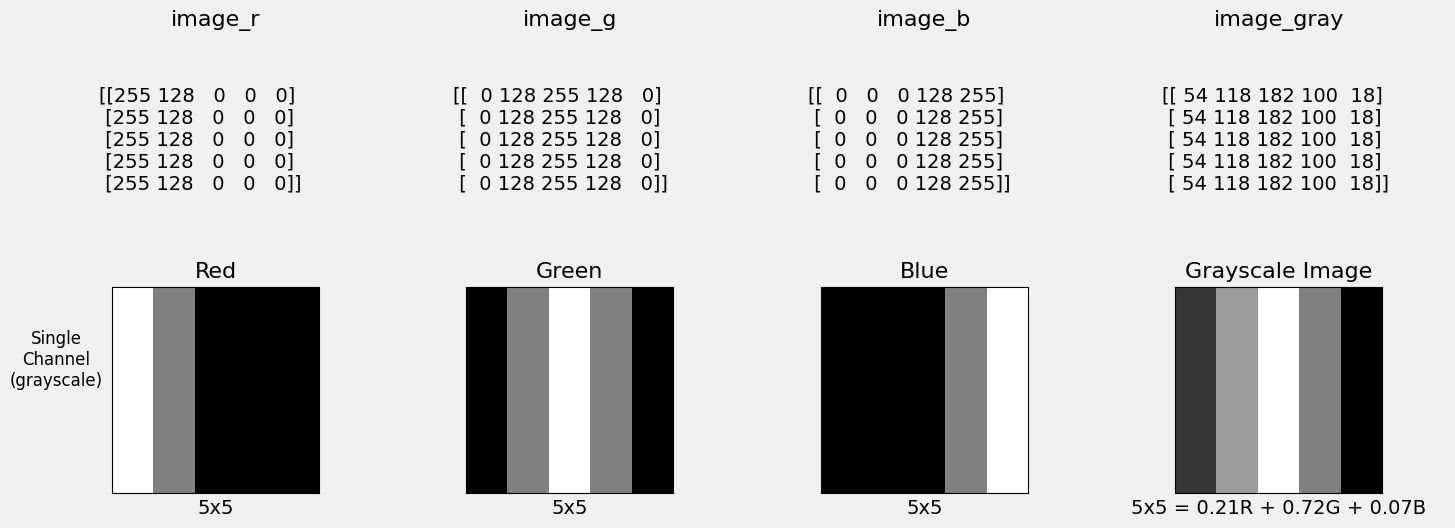

In [ ]:
image_gray = .2126*image_r + .7152*image_g + .0722*image_b
image_rgb = np.stack([image_r, image_g, image_b], axis=2)
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 1))

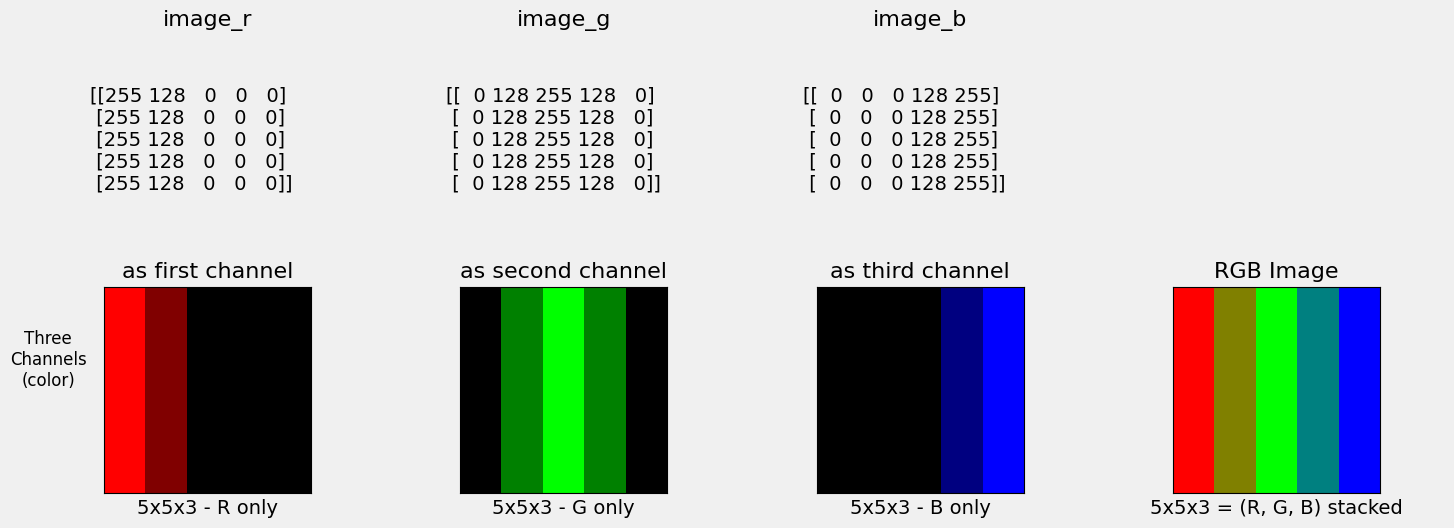

In [ ]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))

## Note on Torchvision

[`torchvision`](https://pytorch.org/vision/0.14/) has many existing `Datasets`, `Models`, and `Transformations`.

### Conversion between ndarray, PIL, and tensor

In [ ]:
images.shape

(300, 1, 5, 5)

In [ ]:
example_chw = images[3]
example_chw

array([[[  0,   0, 255,   0,   0],
        [  0, 255,   0,   0,   0],
        [255,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

In [ ]:
example_chw.shape

(1, 5, 5)

In [ ]:
example_hwc = np.transpose(example_chw, (1,2,0))
example_hwc.shape

(5, 5, 1)

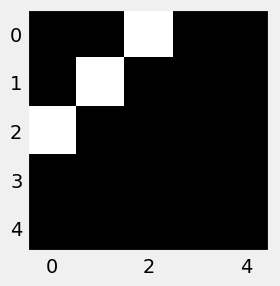

In [ ]:
show_image(example_hwc, 'gray')

`ToTensor`:
Converts a PIL Image or numpy.ndarray (H x W x C) in the range
[0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
or if the numpy.ndarray has dtype = np.uint8

`torch.as_tensor` can work on N-dimensional arrays (ToTensor works only on 2D/3D images), but doesn't apply scalling and, just fyi, it shares data i.e. doesn't make a copy.

In [ ]:
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [ ]:
example_tensor

tensor([[[0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [ ]:
type(example_tensor)

torch.Tensor

In [ ]:
example_pil = ToPILImage()(example_tensor)
print(type(example_pil))

<class 'PIL.Image.Image'>


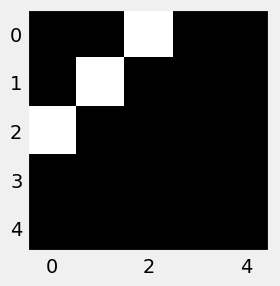

In [ ]:
show_image(example_pil, 'gray')

To convert between numpy and PIL:

In [ ]:
example_np = np.array(example_pil)
print(type(example_np))

<class 'numpy.ndarray'>


In [ ]:
example_pil_back = Image.fromarray(example_np)
print(type(example_pil_back))

<class 'PIL.Image.Image'>


more options for different PIL [modes](https://pillow.readthedocs.io/en/stable/handbook/concepts.html#modes): (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1).


In [ ]:
# PIL_image = Image.fromarray(np.uint8(example_np)).convert('RGB')
# PIL_image = Image.fromarray(example_np.astype('uint8'), 'RGB')

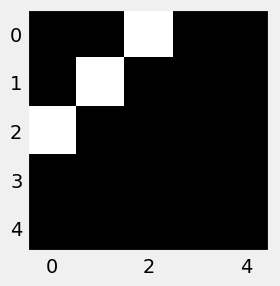

In [ ]:
show_image(example_pil_back, 'gray')

### Transformations

There are many [transformations](https://pytorch.org/vision/stable/transforms.html) that can be done on tensors and/or PIL images:

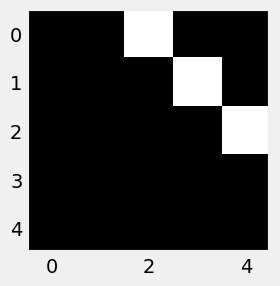

In [ ]:
flipper = RandomHorizontalFlip(p=1.0)
show_image(flipper(example_pil), 'gray')

In [ ]:
print(example_tensor)
normalizer = Normalize(mean=.5, std=.5)
normalized_tensor = normalizer(example_tensor)
print(normalized_tensor)

tensor([[[0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])
tensor([[[-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])


### Composing transforms

In [ ]:
composer = Compose([RandomHorizontalFlip(p=1.0),
                    Normalize(mean=(.5,), std=(.5,))])
composer(example_tensor)

tensor([[[-1., -1.,  1., -1., -1.],
         [-1., -1., -1.,  1., -1.],
         [-1., -1., -1., -1.,  1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

In [ ]:
torch.as_tensor(example_np/255).float()

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

If we want to convert the whole numpy array to tensor we can use:

In [ ]:
example_tensor = torch.as_tensor(example_np / 255).float()
example_tensor

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

PyTorch default floating point `dtype` is `torch.float32`, one can change this if needed via `torch.set_default_dtype(torch.float64)`.

## Samplers

One can also define a [`Sampler`](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) (and it's subclasses: `SequentialSampler`, `RandomSampler`, `SubsetRandomSampler`, `WeightedRandomSampler`, `BatchSampler`, and `DistributedSampler`), use `WeightedRandomSampler` for example in case data is unbalanced.

In [ ]:
composer = Compose([RandomHorizontalFlip(p=0.5),
                    Normalize(mean=.5, std=.5)])

dataset = TransformedTensorDataset(x_tensor, y_tensor, transform=composer)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [ ]:
# Builds a loader of each set
train_loader = DataLoader(dataset=dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=16, sampler=val_sampler)

Note that we need `val_sampler` just because we are passing the full dataset.

Also note that when using `Sampler`s, one can't use `shuffle=True` in `DataLoaders.

In [ ]:
len(iter(train_loader)), len(iter(val_loader))

(15, 4)